In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras.layers import Dense,Flatten,Conv2D, Dropout,BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Activation, Reshape, Conv2DTranspose,UpSampling2D, Input
from keras.optimizers import RMSprop


Using TensorFlow backend.


In [0]:
img = "../../content/drive/My Drive/headphones.npy"
data = np.load(img)

In [3]:
data.shape

(118906, 784)

In [4]:
data.shape[0]

118906

In [0]:
data = data / 255
data = np.reshape(data, (data.shape[0], 28,28,1))

In [0]:
img_w, img_h = data.shape[1:3]

In [0]:
def dicrimintor_builder(width=64, p=0.4):
    inputs = Input((img_w, img_h, 1))
    
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, output=output)
    model.summary()
    return model
    

In [0]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [10]:
discrimintor = dicrimintor_builder()
discrimintor.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [13]:
generator = generator_builder()
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discrimintor)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

In [14]:
adversarial_model = adversarial_builder()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4305409   
Total params: 4,702,370
Trainable params: 4,695,986
Non-trainable params: 6,384
_________________________________________________________________


In [0]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discrimintor, True)
        
        d_metrics.append(discrimintor.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discrimintor, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

0
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
Epoch #500
499: [D loss: 0.503548, acc: 0.770111]  [A loss: 1.594573, acc: 0.091355]


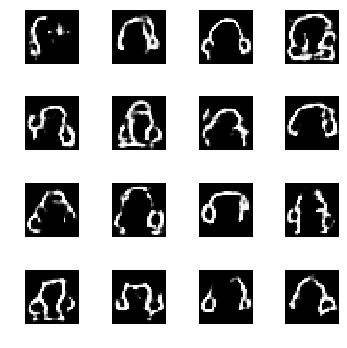

500
600
700
800
900
Epoch #1000
999: [D loss: 0.557616, acc: 0.722007]  [A loss: 1.388670, acc: 0.110235]


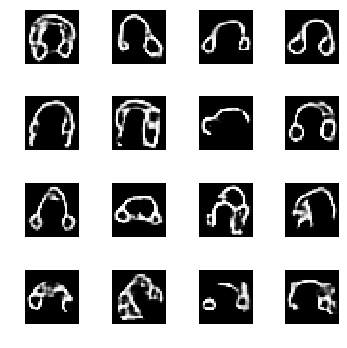

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.572207, acc: 0.709007]  [A loss: 1.361371, acc: 0.119137]


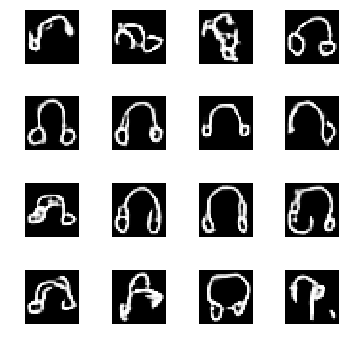

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.576786, acc: 0.705470]  [A loss: 1.379722, acc: 0.122675]


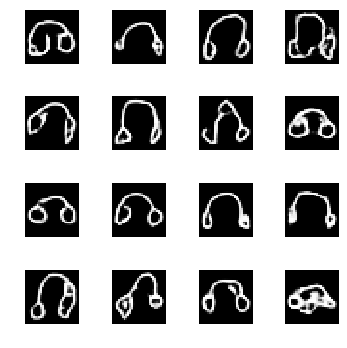

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.577235, acc: 0.706231]  [A loss: 1.421258, acc: 0.122580]


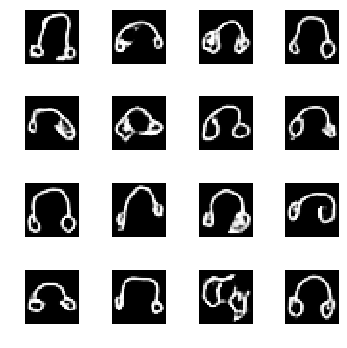

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.576298, acc: 0.708112]  [A loss: 1.464040, acc: 0.122369]


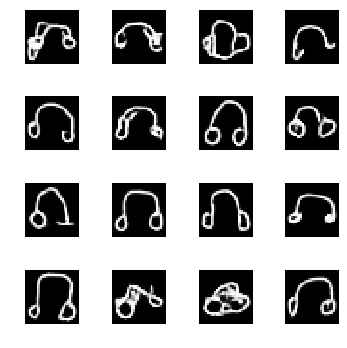

In [18]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)